# wGMM–UAPCA Demonstration

This notebook demonstrates the use of the wGMM–UAPCA method, as described by Klötzl et al. in [*Uncertainty-Aware PCA for Arbitrarily Distributed Data Modeled by Gaussian Mixture Models*](https://arxiv.org/abs/2508.13990), for dataset visualization and weight-sensitive projections.

In this notebook we will perform the following steps:
1. Import necessary packages
2. Load a dataset
3. Fit Gaussian Mixture Models (GMMs) per label
4. Explore different weighting schemes
5. Visualize the resulting projections
6. Interactively tune the weights

## 1. Imports and Setup

Load the main `wgmm_uapca` library and packages needed.

In [1]:
import wgmm_uapca as wgmm

import numpy as np
import matplotlib.pyplot as plt

## 2. Load Dataset

Choose a dataset name and load it using the utility function. Available dataset names include:

`['bank', 'cifar10', 'cnae9', 'coil20', 'epileptic', 'fashion_mnist', 'fmd', 'har', 'hatespeech', 'hiva', 'imdb', 'secom', 'seismic', 'sentiment', 'sms', 'spambase', 'svhn']`

For this demonstration, we use **`hatespeech_demo`**, which is identical to the `hatespeech` dataset except that the **random seeds for Gaussian Mixture Model fitting are set differently**.  
This ensures that the resulting projections are visually distinct, making it easier to explore the effects of label weighting with WGMM-UAPCA.

To use a different dataset, simply change the `dataset_name` variable to any of the options listed above.

In [2]:
dataset_name = "hatespeech_demo"

dataset = wgmm.load_dataset(dataset_name)

X, y = dataset

## 3. Fit Gaussian Mixture Models (GMMs)

For each label in the dataset, fit a Gaussian Mixture Model (GMM). These models will be used to compute density contours and perform weighted projections.

In [3]:
gmms = wgmm.fit_gmms(dataset_name, dataset)

## 4. Define Weighting Schemes

We’ll explore three weighting strategies:
- **Sample-Based Weights:** proportional to label frequency  
- **Equal Weights:** uniform across all labels  
- **Dominant Label:** one label receives higher weight while others share the rest

In [4]:
unique_labels = sorted(list(gmms.keys()))
n_labels = len(unique_labels)

# 1. Sample-Based Weights
label_counts = y["Label"].value_counts(normalize=True)
weights_sample = {label: label_counts.get(label, 0) for label in unique_labels}

# 2. Equal Weights
weights_equal = {label: 1.0 / n_labels for label in unique_labels}

# 3. Dominant Weights
weight = 0.80 # Weight for the dominant label, rest is split among others
label_idx = 0 # Index of the dominant label in unique_labels, here we choose the first one
dominant_label = unique_labels[label_idx]
weights_dominant = {}
remaining_weight = (1.0 - weight) / (n_labels - 1) if n_labels > 1 else 0
for label in unique_labels:
    weights_dominant[label] = weight if label == dominant_label else remaining_weight

weighting_schemes = {
    "Sample-Based Weights": weights_sample,
    "Equal Weights": weights_equal,
    f"Dominant Label {dominant_label}": weights_dominant
}

## 5. Visualize Projections for Different Weights

Each weighting scheme produces a unique 2D projection via WGMM-UAPCA. We’ll visualize both the projected data points and their GMM density contours.

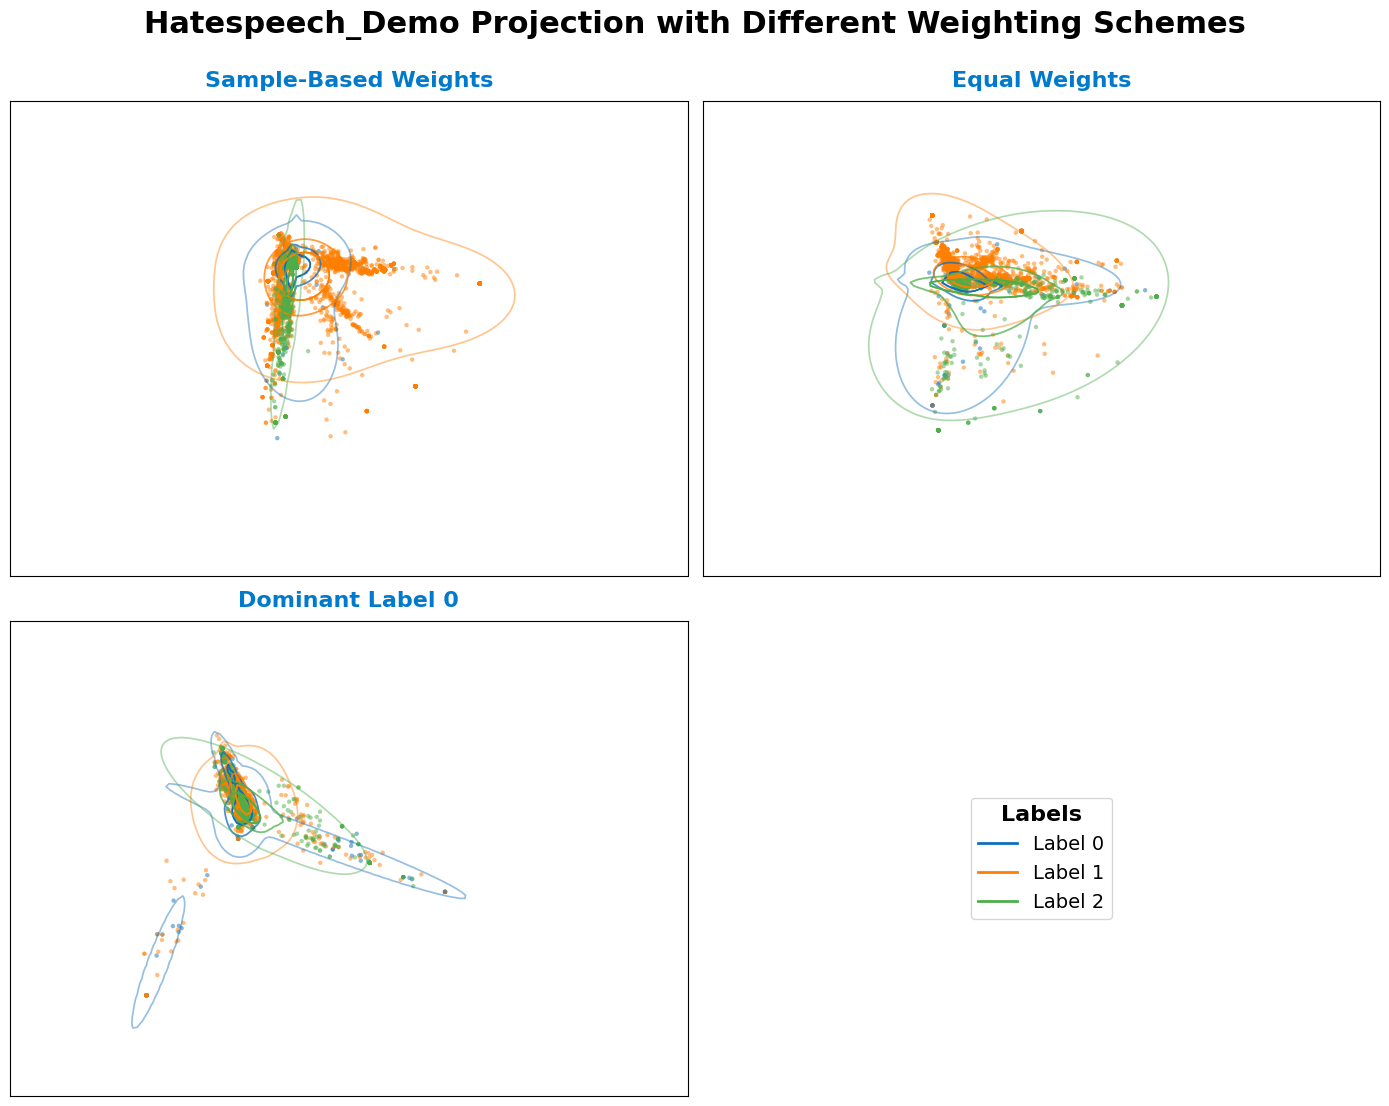

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
axes = axes.flatten()

legend_handles = None

for idx, (title, weights_dict) in enumerate(weighting_schemes.items()):
    if idx >= len(axes) - 1:
        break

    ax = axes[idx]

    # Convert weights dictionary to array in label order
    weights_array = np.array([weights_dict[label] for label in unique_labels])

    # Compute 2D projection
    P = wgmm.calculate_projmat(gmms, weights=weights_array, n_dims=2)
    X_proj = X.values @ P

    # Create grid for density contours
    x_coords, y_coords = wgmm.calculate_grid(gmms, P)
    xx, yy = np.meshgrid(x_coords, y_coords)
    grid = (xx, yy)

    # Project GMM and compute densities
    proj_wgmm = wgmm.wgmm_uapca(gmms, P)
    densities = wgmm.calculate_density(proj_wgmm, grid)

    # Scatter plot of projected data
    for i, label in enumerate(unique_labels):
        mask = y["Label"] == label
        ax.scatter(
            X_proj[mask, 0], X_proj[mask, 1],
            s=10, alpha=0.5,
            color=wgmm.plot_colors[i],
            edgecolors="none"
        )

    # Plot density contours and capture legend handles
    handles = wgmm.plot_contours(ax, xx, yy, densities, unique_labels)
    if legend_handles is None:
        legend_handles = handles

    # Subplot title styling
    ax.set_title(title, fontsize=16, fontweight="600", pad=10, color="#007acc")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("white")

# Bottom-right subplot for legend
legend_ax = axes[-1]
legend_ax.axis("off")
legend = legend_ax.legend(
    handles=legend_handles,
    loc="center",
    fontsize=14,
    title="Labels",
    title_fontsize=16,
    ncols=2 if len(unique_labels) > 8 else 1, # Split Legend into 2 columns if many labels are present 
)
legend_title = legend.get_title()
legend_title.set_fontweight("bold")

# Overall figure title
fig.suptitle(
    f"{dataset_name.title()} Projection with Different Weighting Schemes",
    fontsize=22, fontweight="800", y=1.001
)

plt.tight_layout()
plt.show()

## 6. Interactive Weight Adjustment

Use the interactive visualization below to **adjust the label weights dynamically** and observe how the projection and mixture contours respond in real time.

### Controls Overview
- **Sliders** – Control the relative weight of each label. The weights are normalized so that their total always equals 1.  
- **Equal** – Sets all weights to equal values across labels.  
- **Sample-Based** – Sets weights proportional to the number of samples per label.  
- **Update Plot** – Redraws the visualization using the current weights (useful when *Auto Update* is turned off).  
- **Auto Update Plot** – When enabled, the plot automatically updates after each slider change, turn off to manually adjust multiple sliders before they get normalized and the plot updated.

In [ ]:
wgmm.create_interactive_plot(dataset_name, dataset, gmms)